# Preparation & peek at the data structure <a class="anchor" id="prep"></a>

## Loading packages and setting <a class="anchor" id="setup"></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

### Settings

In [2]:
run_training = False
retrain = False
find_learning_rate = False

## Exploring the data structure <a class="anchor" id="explorestructure"></a>

In [3]:
files = listdir("../../datasets/bhi/")
print(len(files))

280


In [4]:
files[0:10]

['12871',
 '13460',
 '15513',
 '10269',
 '9324',
 '12875',
 '12951',
 '12824',
 '10302',
 '14210']

Ok, in this folder we should find several images or a further substructure of folders.

In [5]:
files = listdir("../../datasets/bhi/IDC_regular_ps50_idx5/")
len(files)

279

In [6]:
base_path = "../../datasets/bhi/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [7]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [8]:
total_images

277524

### Storing the image_path, patient_id and the target

In [9]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,12871,../../datasets/bhi/IDC_regular_ps50_idx5/12871...,0
1,12871,../../datasets/bhi/IDC_regular_ps50_idx5/12871...,0
2,12871,../../datasets/bhi/IDC_regular_ps50_idx5/12871...,0
3,12871,../../datasets/bhi/IDC_regular_ps50_idx5/12871...,0
4,12871,../../datasets/bhi/IDC_regular_ps50_idx5/12871...,0


Ok, now for each patient we know the path for each patch as well as if it contains IDC or not (the target).

In [10]:
data.shape

(277524, 3)

No surprise. This matches the total number of patches. 

# Exploratory analysis <a class="anchor" id="eda"></a>

## What do we know about our data? <a class="anchor" id="data"></a>

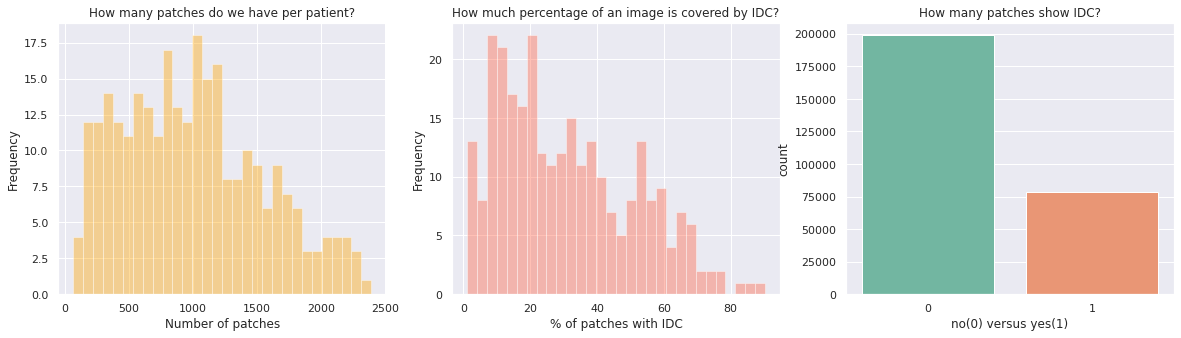

In [11]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

## Looking at healthy and cancer patches <a class="anchor" id="patches"></a>

In [12]:
data.target = data.target.astype(np.int)

In [13]:
np.random.choice(data[data.target==1].index.values,size=50,replace=False)

array([ 89055,  90949, 179771, 138357, 121551, 101447,  15510,  77139,
       255889, 247820,  15239, 262506, 172531, 100195,   3728,  68378,
       197776, 160295, 238479, 181431, 182854, 100211,  64715,  81338,
       114741, 164449, 127378, 101441,  55808, 218244,  25614, 189441,
       235386,  38221,  25241, 201167, 147641, 265884, 248978, 113815,
       105726,  49151, 218489,   3817, 268365, 202769, 123349, 250484,
        82190,  20925])

In [14]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

In [15]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [16]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

,x,y,target,path
0,551,1,0,../../datasets/bhi/IDC_regular_ps50_idx5/12871...
1,1051,901,0,../../datasets/bhi/IDC_regular_ps50_idx5/12871...
2,201,401,0,../../datasets/bhi/IDC_regular_ps50_idx5/12871...
3,1201,1151,0,../../datasets/bhi/IDC_regular_ps50_idx5/12871...
4,651,901,0,../../datasets/bhi/IDC_regular_ps50_idx5/12871...


Ok, now we have the coordinates for each patch, its path to load the image and its target information.

### Binary target visualisation per tissue slice <a class="anchor" id="binarytissue"></a>

Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

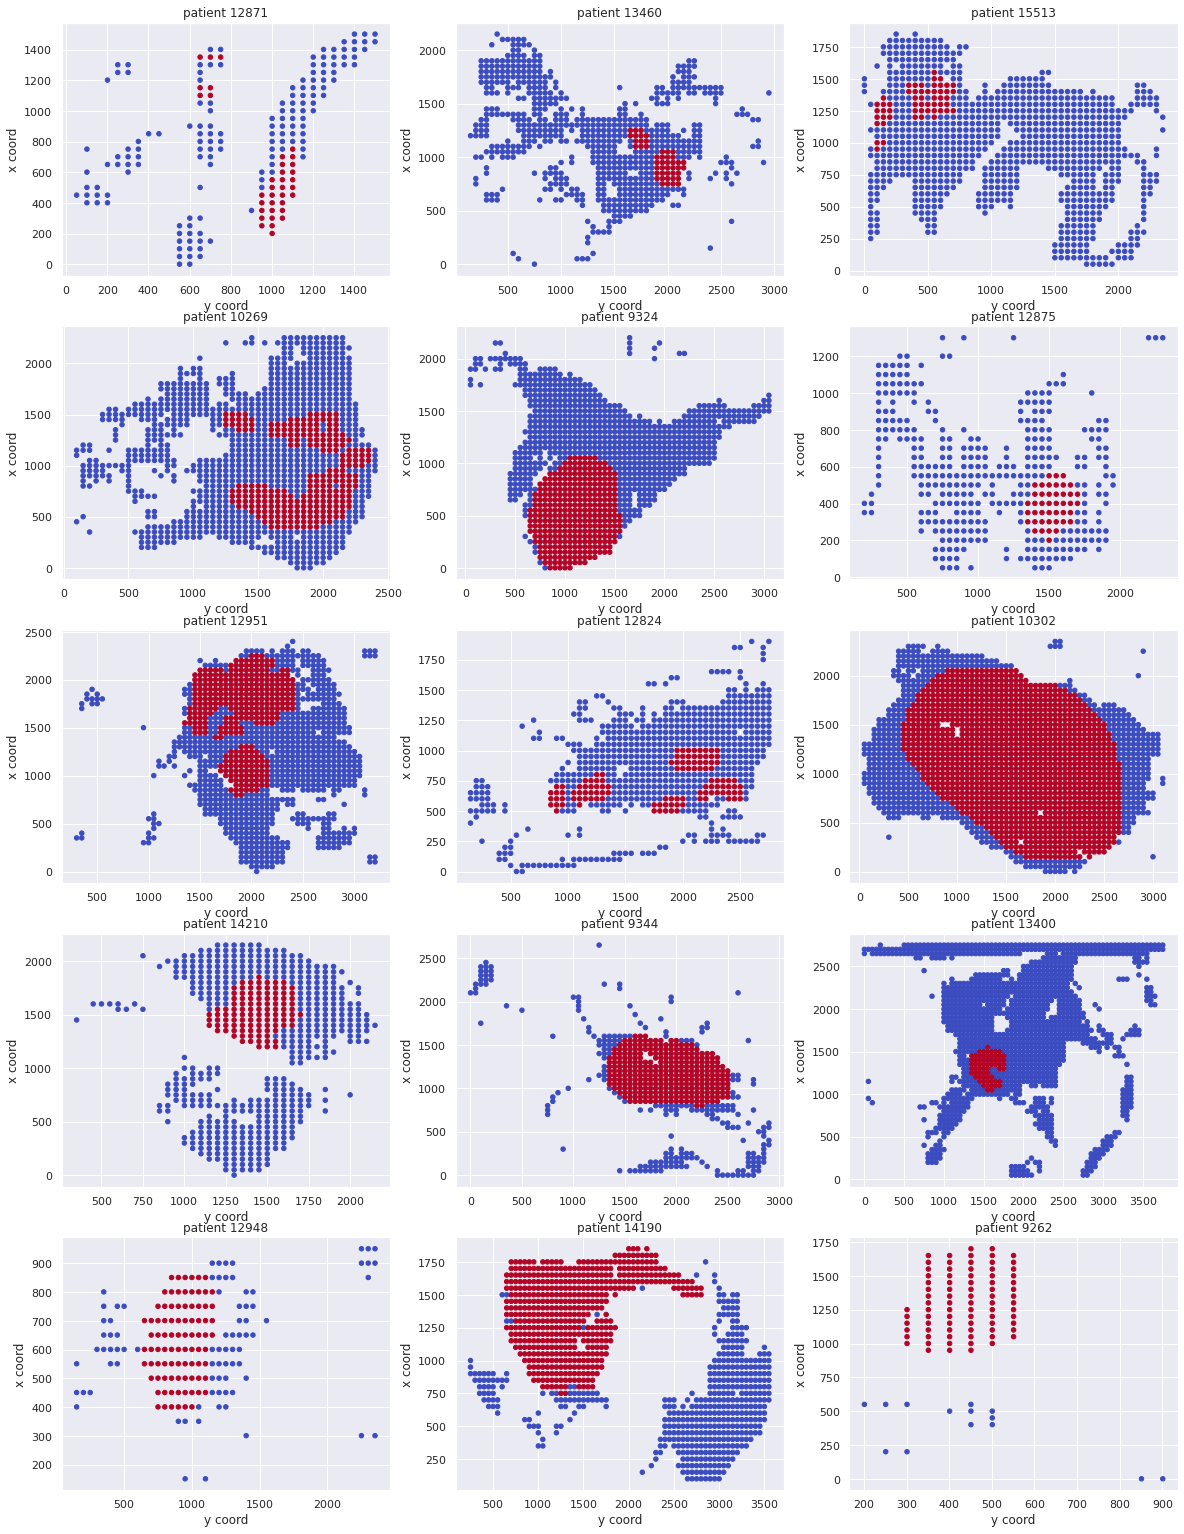

In [17]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

In [18]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

# Setting up the machine learning workflow <a class="anchor" id="workflow"></a>

## Settings <a class="anchor" id="ml_settings"></a>

In [19]:
BATCH_SIZE = 256
NUM_CLASSES = 2

OUTPUT_PATH = "./inceptionv3/"
MODEL_PATH = "./inceptionv3/"
LOSSES_PATH = "./inceptionv3/"

In [20]:
torch.manual_seed(0)
np.random.seed(0)

In [21]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 8.5+ MB


In [22]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [23]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


In [24]:
print(len(train_ids), len(dev_ids), len(test_ids))

195 42 42


In [25]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

In [26]:
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip()]
    val_sequence = [transforms.Resize((50,50))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

In [27]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = np.int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [28]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [29]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

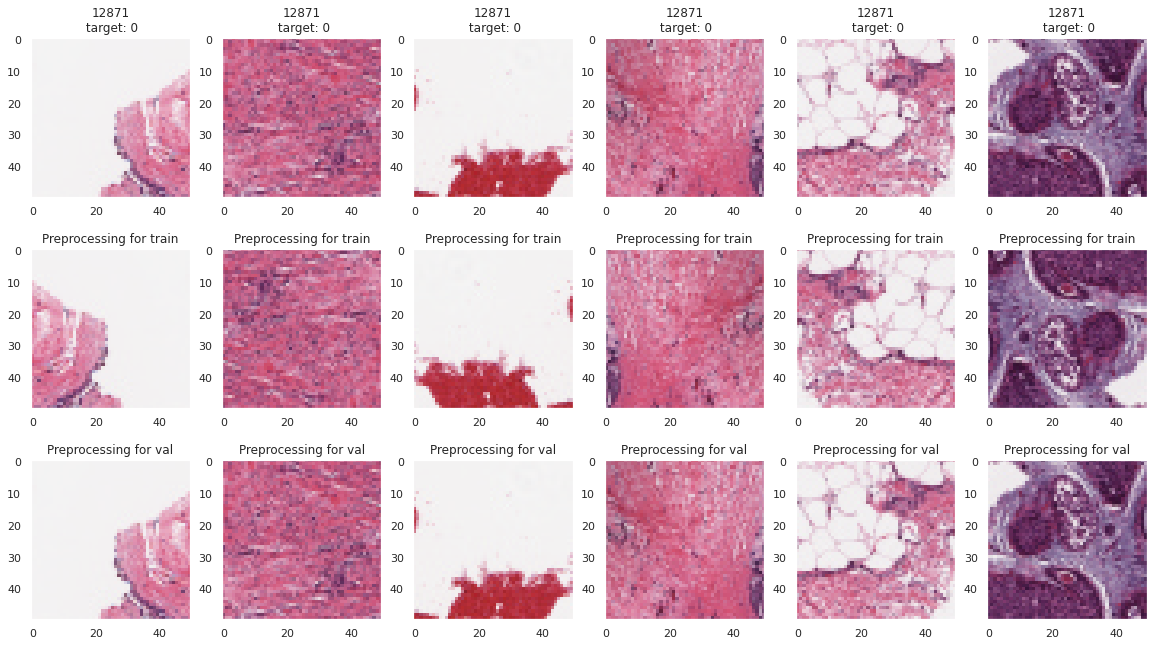

In [30]:
fig, ax = plt.subplots(3,6,figsize=(20,11))

train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

for m in range(6):
    filepath = train_df.path.values[m]
    image = Image.open(filepath)
    ax[0,m].imshow(image)
    transformed_img = train_transform(image)
    ax[1,m].imshow(transformed_img)
    ax[2,m].imshow(val_transform(image))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[2,m].grid(False)
    ax[0,m].set_title(train_df.patient_id.values[m] + "\n target: " + train_df.target.values[m])
    ax[1,m].set_title("Preprocessing for train")
    ax[2,m].set_title("Preprocessing for val")

In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [32]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [33]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

769 165 150


## Defining the model structure <a class="anchor" id="model_structure"></a>

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [35]:
model = torchvision.models.resnext50_32x4d(pretrained=True)
num_features = model.fc.in_features
print(num_features)

2048


In [36]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, NUM_CLASSES)
)
    


In [37]:
model = model.to(device)

In [38]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6801, 1.8884], device='cuda:0')


In [39]:
criterion = nn.CrossEntropyLoss()

In [40]:
def f1_score(preds, targets):
    
    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)
    
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    print("precision: " + str(precision) )
    recall = tp / (tp + fn + epsilon)
    print("recall: " + str(recall) )
    
    
    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

In [41]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)
    
    running_loss_dict = {"train": [], "dev": [], "test": []}
    
    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)
                        
                        #loss += l2_reg
            
                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step() 
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)
                            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                      
     
                counter += 1
                
                
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

In [42]:
start_lr = 1e-6
end_lr = 0.1

In [43]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations 
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, 
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular")
    
    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = np.int(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular")
    return scheduler

In [44]:
find_learning_rate = True

In [45]:
import math

if find_learning_rate:
    lr_find_epochs=1
    optimizer = optim.SGD(model.fc.parameters(), start_lr)
    scheduler = get_lr_search_scheduler(optimizer, start_lr, end_lr, lr_find_epochs*len(train_dataloader))
    results = train_loop(model, criterion, optimizer, lr_find=True, scheduler=scheduler, num_epochs=lr_find_epochs)
    lr_find_lr, lr_find_loss = results["lr_find"]["lr"], results["lr_find"]["loss"]
    
    find_lr_df = pd.DataFrame(lr_find_loss, columns=["smoothed loss"])
    find_lr_df.loc[:, "lr"] = lr_find_lr
    find_lr_df.to_csv("learning_rate_search.csv", index=False)
else:
    find_lr_df = pd.read_csv(MODEL_PATH + "learning_rate_search.csv")

Epoch 0/0
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3821 Acc: 0.8361

Training complete in 4m 58s
Best val Acc: 0.000000


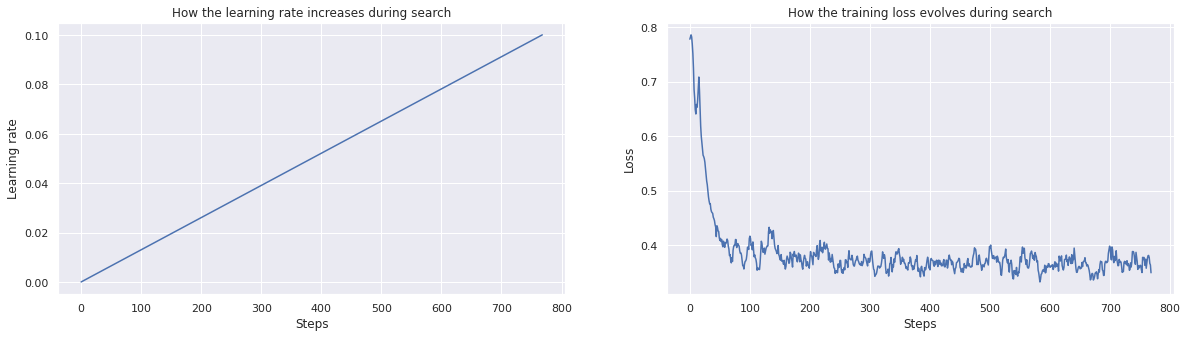

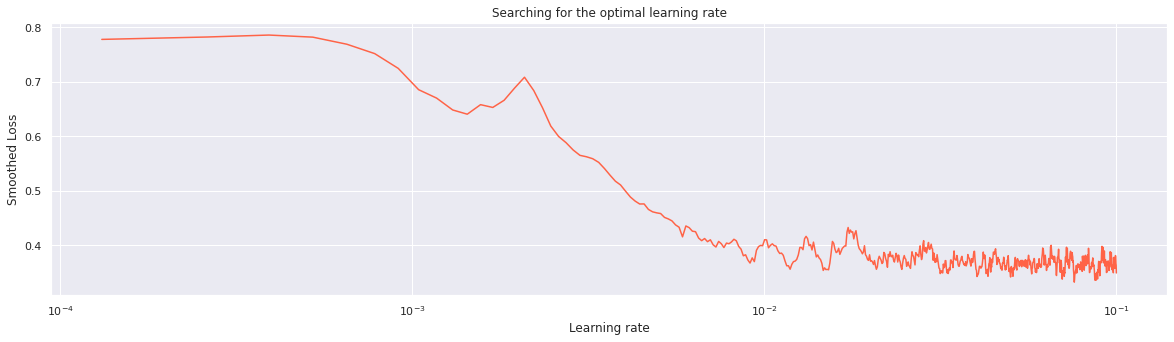

In [46]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(find_lr_df.lr.values)
ax[1].plot(find_lr_df["smoothed loss"].values)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Learning rate")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss");
ax[0].set_title("How the learning rate increases during search")
ax[1].set_title("How the training loss evolves during search")

plt.figure(figsize=(20,5))
plt.plot(find_lr_df.lr.values, find_lr_df["smoothed loss"].values, '-', color="tomato");
plt.xlabel("Learning rate")
plt.xscale("log")
plt.ylabel("Smoothed Loss")
plt.title("Searching for the optimal learning rate");

In [47]:
start_lr = 1e-6
end_lr = 0.006

In [48]:
run_training = True

## Performing the training or loading results <a class="anchor" id="run"></a>

In [49]:
if run_training:
    NUM_EPOCHS = 30
    optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
    scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*NUM_EPOCHS)
    results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
    model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]
    
    if device == "cpu":
        OUTPUT_PATH += ".pth"
    else:
        OUTPUT_PATH += "_cuda.pth"
        
    torch.save(model.state_dict(), OUTPUT_PATH)
    
    losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
    losses_df.loc[:, "dev"] = loss_dict["dev"]
    losses_df.loc[:, "test"] = loss_dict["test"]
    losses_df.to_csv("losses_breastcancer.csv", index=False)
    
    running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
    running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
    running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
    running_losses_df.to_csv("running_losses_breastcancer.csv", index=False)
else:
    if device == "cpu":
        load_path = MODEL_PATH + ".pth"
    else:
        load_path = MODEL_PATH + "_cuda.pth"
    model.load_state_dict(torch.load(load_path, map_location='cpu'))
    model.eval()
    
    losses_df = pd.read_csv(LOSSES_PATH + "losses_breastcancer.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_breastcancer.csv")

Epoch 0/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3821 Acc: 0.8362


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3694 Acc: 0.8470


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3906 Acc: 0.8346

Epoch 1/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3576 Acc: 0.8485


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3675 Acc: 0.8473


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3915 Acc: 0.8334

Epoch 2/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3542 Acc: 0.8500


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3562 Acc: 0.8517


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3747 Acc: 0.8431

Epoch 3/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3511 Acc: 0.8514


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3603 Acc: 0.8501


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3839 Acc: 0.8361

Epoch 4/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3494 Acc: 0.8510


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3649 Acc: 0.8489


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3897 Acc: 0.8342

Epoch 5/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3483 Acc: 0.8520


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3657 Acc: 0.8463


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3917 Acc: 0.8311

Epoch 6/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3474 Acc: 0.8532


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3580 Acc: 0.8507


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3815 Acc: 0.8378

Epoch 7/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3457 Acc: 0.8536


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3576 Acc: 0.8509


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3824 Acc: 0.8385

Epoch 8/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3461 Acc: 0.8528


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3614 Acc: 0.8493


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3863 Acc: 0.8360

Epoch 9/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3462 Acc: 0.8530


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3573 Acc: 0.8506


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3814 Acc: 0.8382

Epoch 10/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3465 Acc: 0.8537


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3544 Acc: 0.8524


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3774 Acc: 0.8417

Epoch 11/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3441 Acc: 0.8539


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3536 Acc: 0.8529


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3791 Acc: 0.8400

Epoch 12/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3442 Acc: 0.8543


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3679 Acc: 0.8469


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3933 Acc: 0.8317

Epoch 13/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3451 Acc: 0.8536


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3539 Acc: 0.8523


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3765 Acc: 0.8410

Epoch 14/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3460 Acc: 0.8524


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3593 Acc: 0.8484


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3831 Acc: 0.8363

Epoch 15/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3443 Acc: 0.8543


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3598 Acc: 0.8498


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3843 Acc: 0.8368

Epoch 16/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3432 Acc: 0.8545


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3538 Acc: 0.8525


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3766 Acc: 0.8419

Epoch 17/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3432 Acc: 0.8539


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3730 Acc: 0.8436


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.4000 Acc: 0.8278

Epoch 18/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3438 Acc: 0.8544


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3512 Acc: 0.8525


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3719 Acc: 0.8429

Epoch 19/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3428 Acc: 0.8544


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3545 Acc: 0.8511


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3779 Acc: 0.8410

Epoch 20/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3438 Acc: 0.8546


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3571 Acc: 0.8502


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3795 Acc: 0.8394

Epoch 21/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3430 Acc: 0.8544


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3682 Acc: 0.8460


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3950 Acc: 0.8290

Epoch 22/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3431 Acc: 0.8550


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3578 Acc: 0.8504


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3833 Acc: 0.8373

Epoch 23/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3436 Acc: 0.8541


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3674 Acc: 0.8455


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3950 Acc: 0.8296

Epoch 24/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3421 Acc: 0.8552


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3620 Acc: 0.8474


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3875 Acc: 0.8337

Epoch 25/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3432 Acc: 0.8545


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3520 Acc: 0.8533


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3742 Acc: 0.8432

Epoch 26/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3439 Acc: 0.8541


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3613 Acc: 0.8476


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3875 Acc: 0.8341

Epoch 27/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3427 Acc: 0.8544


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3555 Acc: 0.8503


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3793 Acc: 0.8394

Epoch 28/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3428 Acc: 0.8542


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3577 Acc: 0.8500


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3835 Acc: 0.8373

Epoch 29/29
----------


  0%|          | 0/769 [00:00<?, ?it/s]

train Loss: 0.3425 Acc: 0.8544


  0%|          | 0/165 [00:00<?, ?it/s]

dev Loss: 0.3566 Acc: 0.8518


  0%|          | 0/150 [00:00<?, ?it/s]

test Loss: 0.3787 Acc: 0.8396

Training complete in 159m 21s
Best val Acc: 0.853304


# Exploring results and errors <a class="anchor" id="error_analysis"></a>

## Loss convergence <a class="anchor" id="losses"></a>

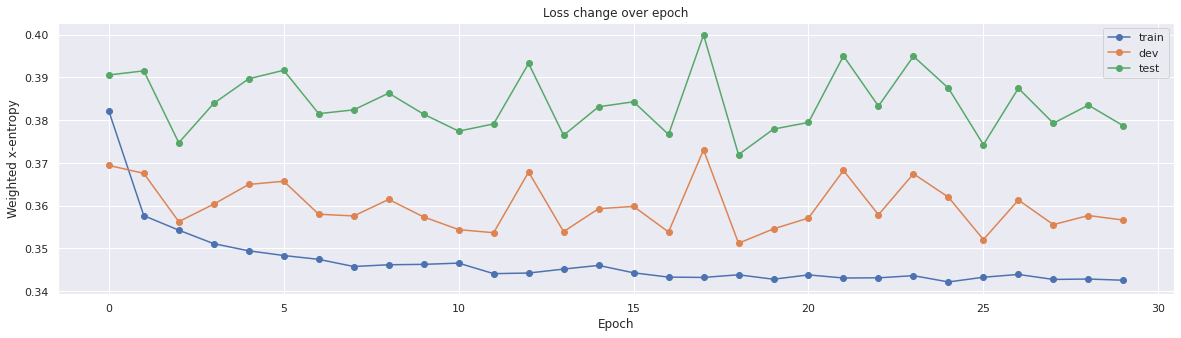

In [50]:
plt.figure(figsize=(20,5))

plt.plot(losses_df["train"], '-o', label="train")
plt.plot(losses_df["dev"], '-o', label="dev")
plt.plot(losses_df["test"], '-o', label="test")
plt.xlabel("Epoch")
plt.ylabel("Weighted x-entropy")
plt.title("Loss change over epoch")
plt.legend();

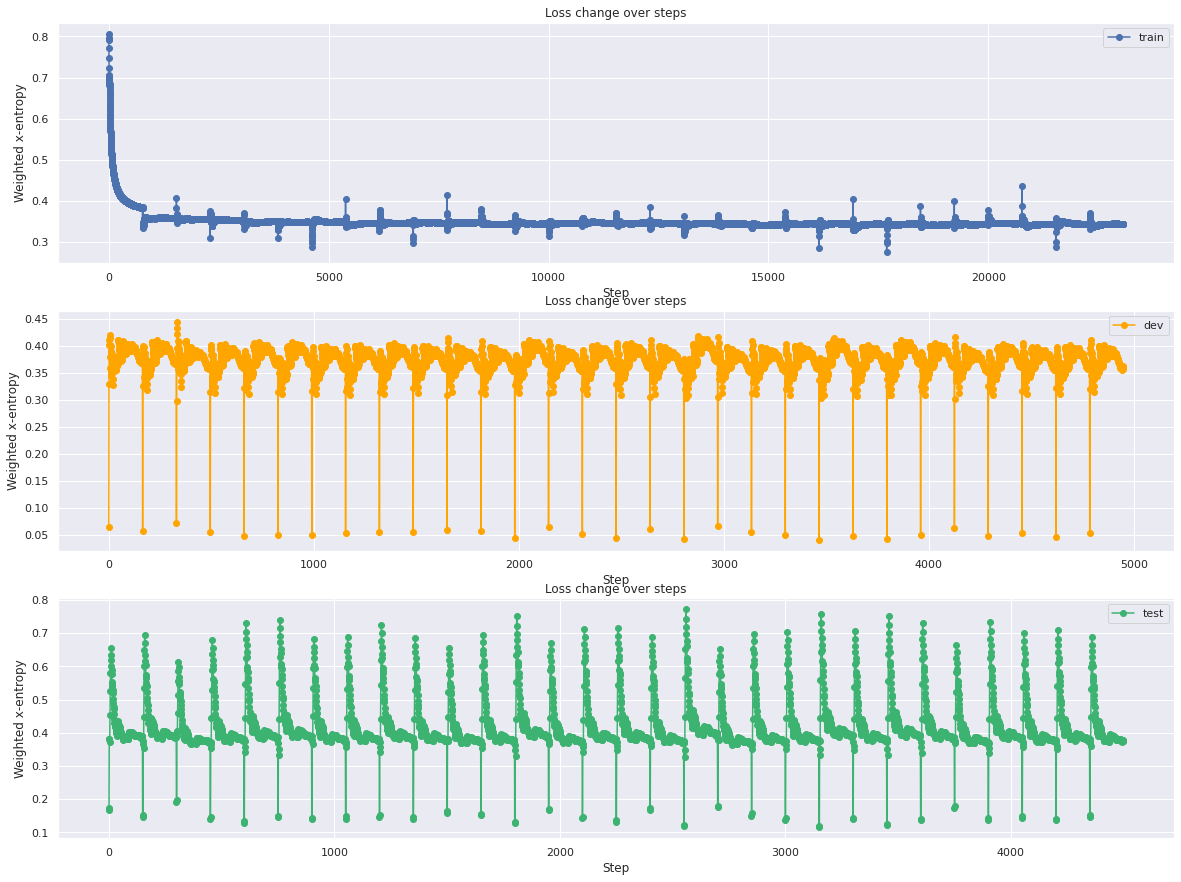

In [51]:
fig, ax = plt.subplots(3,1,figsize=(20,15))

ax[0].plot(running_losses_df["train"], '-o', label="train")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Weighted x-entropy")
ax[0].set_title("Loss change over steps")
ax[0].legend();

ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Weighted x-entropy")
ax[1].set_title("Loss change over steps")
ax[1].legend();

ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Weighted x-entropy")
ax[2].set_title("Loss change over steps")
ax[2].legend();

## The probability landscape of invasive ductal carcinoma <a class="anchor" id="landscape"></a>

In [52]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            proba = outputs.cpu().numpy().astype(np.float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]
            
    predictions_df = predictions_df.dropna()
    return predictions_df

In [53]:
run_training = True
if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")
    
    dev_predictions.to_csv("dev_predictions.csv", index=False)
    test_predictions.to_csv("test_predictions.csv", index=False)
    
else:
    
    dev_predictions = pd.read_csv(LOSSES_PATH + "dev_predictions.csv")
    test_predictions = pd.read_csv(LOSSES_PATH + "test_predictions.csv")
    
    dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

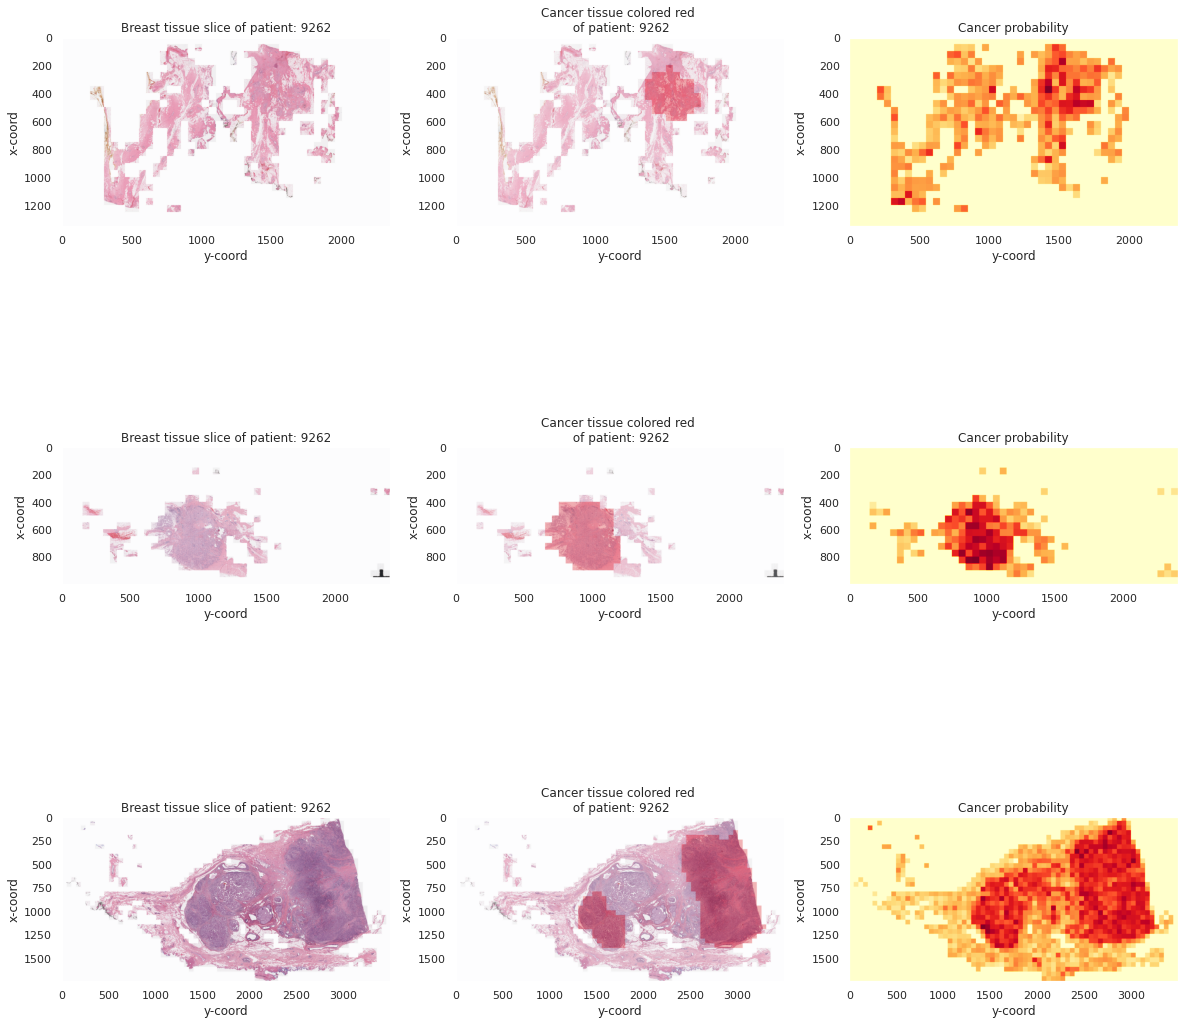

In [54]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

for n in range(3):

    idx = dev_predictions.patient_id.unique()[n]
    grid, mask, broken_patches, mask_proba = visualise_breast_tissue(idx, pred_df=dev_predictions)


    ax[n, 0].imshow(grid, alpha=0.9)
    ax[n, 1].imshow(mask, alpha=0.8)
    ax[n, 1].imshow(grid, alpha=0.7)
    ax[n, 2].imshow(mask_proba[:,:,0], cmap="YlOrRd")

    for m in range(3):
        ax[n, m].set_xlabel("y-coord")
        ax[n, m].set_ylabel("x-coord")
        ax[n, m].grid(False)
        
    ax[n, 0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[n, 1].set_title("Cancer tissue colored red \n of patient: " + patient_id);
    ax[n, 2].set_title("Cancer probability");

## Going into details

In [55]:
dev_predictions.head()

,true,predicted,proba,x,y,patient_id
0,0,0,0.458478,1001.0,351.0,12875
1,0,0,0.28728,1501.0,651.0,12875
2,0,0,0.202621,851.0,501.0,12875
3,0,0,0.146564,801.0,51.0,12875
4,0,0,0.257191,1501.0,901.0,12875


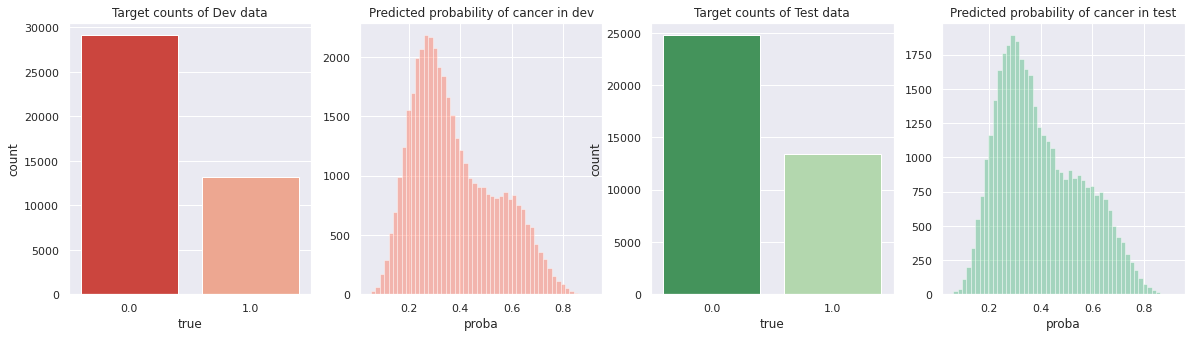

In [56]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
sns.countplot(dev_predictions.true.astype(np.float), ax=ax[0], palette="Reds_r")
ax[0].set_title("Target counts of Dev data");
sns.distplot(dev_predictions.proba.astype(np.float), ax=ax[1], kde=False, color="tomato")
ax[1].set_title("Predicted probability of cancer in dev");
sns.countplot(test_predictions.true.astype(np.float), ax=ax[2], palette="Greens_r")
ax[2].set_title("Target counts of Test data");
sns.distplot(test_predictions.proba.astype(np.float), ax=ax[3], kde=False, color="mediumseagreen");
ax[3].set_title("Predicted probability of cancer in test");

In [57]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "cancer", 0: "no cancer"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])
    
    labels = ["no cancer", "cancer"]
    index_labels = ["actual no cancer", "actual cancer"]
    col_labels = ["predicted no cancer", "predicted cancer"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df



## Dev Prediction Results Analysis

In [58]:
# DEV
print('DEV')
print(dev_predictions)

DEV
      true predicted     proba       x       y patient_id
0        0         0  0.458478  1001.0   351.0      12875
1        0         0   0.28728  1501.0   651.0      12875
2        0         0  0.202621   851.0   501.0      12875
3        0         0  0.146564   801.0    51.0      12875
4        0         0  0.257191  1501.0   901.0      12875
...    ...       ...       ...     ...     ...        ...
42235    0         0  0.202689  3251.0  2201.0      12870
42236    0         0  0.167683   601.0  2501.0      12870
42237    0         0  0.328634  1601.0  2301.0      12870
42238    0         0  0.230399  1901.0  2101.0      12870
42239    0         0  0.206785  1301.0  2701.0      12870

[42240 rows x 6 columns]


In [59]:
#print(classification_report(dev_predictions.true, dev_predictions.predicted, target_names=['actual no cancer', 'actual cancer']))
dev_predictions.true.astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
42235    0
42236    0
42237    0
42238    0
42239    0
Name: true, Length: 42240, dtype: int64

Confusion Matrix - Dev (Validation) 

                  predicted no cancer  predicted cancer
actual no cancer             0.936776          0.063224
actual cancer                0.324413          0.675587

                  precision    recall  f1-score   support

actual no cancer       0.86      0.94      0.90     29087
   actual cancer       0.83      0.68      0.74     13153

        accuracy                           0.86     42240
       macro avg       0.85      0.81      0.82     42240
    weighted avg       0.85      0.86      0.85     42240


Balanced Accuracy score: 0.8061815988706253

AUC score:
0.5


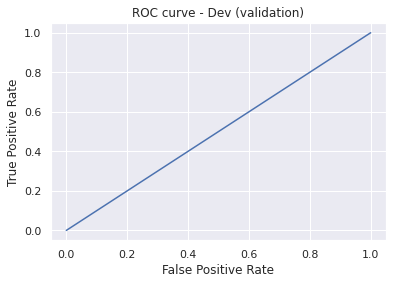

In [60]:
print('Confusion Matrix - Dev (Validation) \n')

conf_matrix_dev = get_confusion_matrix(dev_predictions.true, dev_predictions.predicted)
print(conf_matrix_dev)
# print(f1_score(dev_predictions.predicted, dev_predictions.true))

print('')
from sklearn.metrics import classification_report,balanced_accuracy_score, roc_curve,roc_auc_score
print(classification_report(dev_predictions.true.astype(int), dev_predictions.predicted.astype(int), target_names=['actual no cancer', 'actual cancer']))

print('\nBalanced Accuracy score: ' + str( balanced_accuracy_score(dev_predictions.true.astype(int), dev_predictions.predicted.astype(int))))

fpr, tpr, thresholds = roc_curve(dev_predictions.true.astype(int), dev_predictions.proba.astype(int))


fig, ax = plt.subplots(1,1)
ax.plot(fpr,tpr); ax.set_xlabel('False Positive Rate') ; ax.set_ylabel('True Positive Rate'); plt.title('ROC curve - Dev (validation)')
# print(thresholds)

auc_score_dev = roc_auc_score(dev_predictions.true.astype(int), dev_predictions.proba.astype(int))
print('\nAUC score:')
print(auc_score_dev)

## Test prediction results analysis

In [61]:
print(test_predictions)

      true predicted     proba       x       y patient_id
0        0         0  0.326836   851.0   751.0      12824
1        0         0  0.283578  2651.0  1501.0      12824
2        0         0  0.275742  2451.0  1501.0      12824
3        0         0  0.235356  2601.0   901.0      12824
4        0         0  0.200215  1601.0  1251.0      12824
...    ...       ...       ...     ...     ...        ...
38178    1         1  0.511023  1101.0   751.0      12876
38179    1         0  0.274736   701.0   801.0      12876
38180    1         0  0.312714   651.0   601.0      12876
38181    1         0  0.291266   451.0   501.0      12876
38182    1         0  0.244611  1301.0   251.0      12876

[38183 rows x 6 columns]


Confusion Matrix - Test set 

                  predicted no cancer  predicted cancer
actual no cancer             0.931916          0.068084
actual cancer                0.320158          0.679842

                  precision    recall  f1-score   support

actual no cancer       0.84      0.93      0.89     24749
   actual cancer       0.84      0.68      0.75     13434

        accuracy                           0.84     38183
       macro avg       0.84      0.81      0.82     38183
    weighted avg       0.84      0.84      0.84     38183


Balanced Accuracy score: 0.8058793162614222

AUC score:
0.5


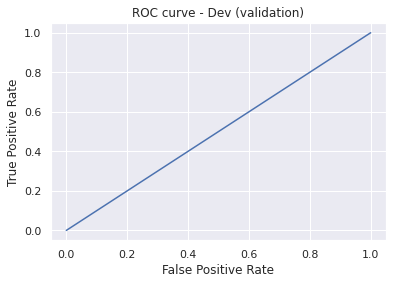

In [62]:
print("Confusion Matrix - Test set \n")
conf_matrix_test = get_confusion_matrix(test_predictions.true, test_predictions.predicted)
print(conf_matrix_test)
# print(f1_score(test_predictions.predicted, test_predictions.true))

print('')
from sklearn.metrics import classification_report, balanced_accuracy_score

print(classification_report(test_predictions.true.astype(int), test_predictions.predicted.astype(int), target_names=['actual no cancer', 'actual cancer']))

print('\nBalanced Accuracy score: ' + str(balanced_accuracy_score(test_predictions.true.astype(int), test_predictions.predicted.astype(int))))


fpr, tpr, thresholds = roc_curve(test_predictions.true.astype(int), test_predictions.proba.astype(int))


fig, ax = plt.subplots(1,1)
ax.plot(fpr,tpr); ax.set_xlabel('False Positive Rate') ; ax.set_ylabel('True Positive Rate'); plt.title('ROC curve - Dev (validation)')
# print(thresholds)

auc_score_dev = roc_auc_score(test_predictions.true.astype(int), test_predictions.proba.astype(int))
print('\nAUC score:')
print(auc_score_dev)

In [63]:
conf_matrix_test

,predicted no cancer,predicted cancer
actual no cancer,0.931916,0.068084
actual cancer,0.320158,0.679842


In [64]:
conf_matrix_dev

,predicted no cancer,predicted cancer
actual no cancer,0.936776,0.063224
actual cancer,0.324413,0.675587
